In [126]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM, Dense, Dropout
from IPython.display import clear_output

In [2]:


df  = pd.read_csv("/content/drive/MyDrive/projectDatabase/AAPL_HistoricalData.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True , ascending=True)
df.index = df['Date']

df

,Date,Close/Last,Volume,Open,High,Low
Date,,,,,,
2010-03-01,2010-03-01,$29.8557,137312041,$29.3928,$29.9286,$29.35
2010-03-02,2010-03-02,$29.8357,141486282,$29.99,$30.1186,$29.6771
2010-03-03,2010-03-03,$29.9043,92846488,$29.8486,$29.9814,$29.7057
2010-03-04,2010-03-04,$30.1014,89591907,$29.8971,$30.1314,$29.8043
2010-03-05,2010-03-05,$31.2786,224647427,$30.7057,$31.3857,$30.6614
...,...,...,...,...,...,...
2020-02-24,2020-02-24,$298.18,55548830,$297.26,$304.18,$289.23
2020-02-25,2020-02-25,$288.08,57668360,$300.95,$302.53,$286.13
2020-02-26,2020-02-26,$292.65,49678430,$286.53,$297.88,$286.5


In [3]:
df.columns = df.columns.str.strip()
df.columns.values

array(['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low'],
      dtype=object)

In [4]:
df = df[['Volume']]
df.head(n=10)

,Volume
Date,
2010-03-01,137312041
2010-03-02,141486282
2010-03-03,92846488
2010-03-04,89591907
2010-03-05,224647427
2010-03-08,107326832
2010-03-09,229908139
2010-03-10,148907755
2010-03-11,101209110


<Axes: xlabel='Date'>

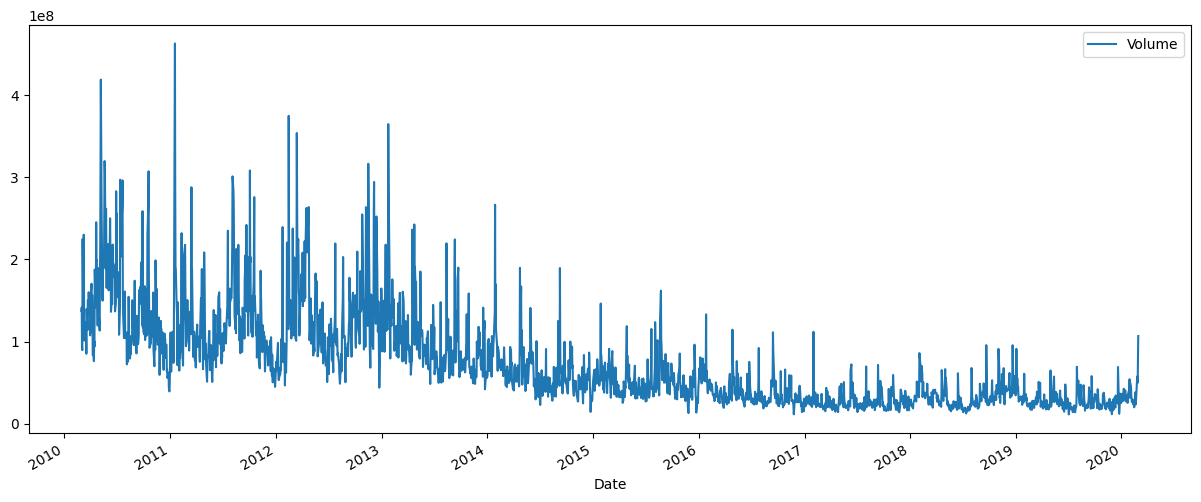

In [5]:
df.plot(figsize=(15,6))

Let's check the seasonal signals

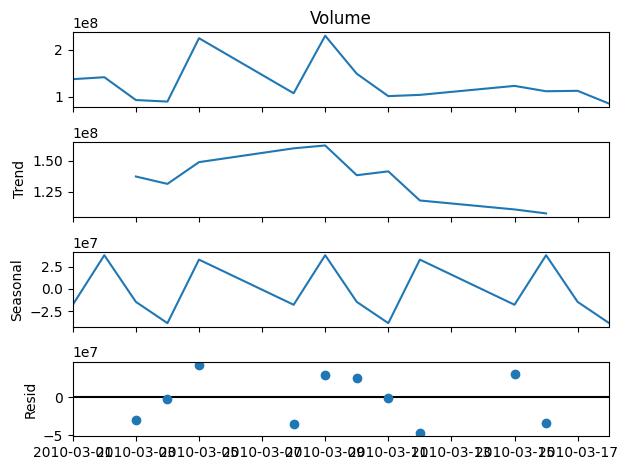

In [6]:
graph = seasonal_decompose(df['Volume'].iloc[:14] )
graph.plot();

In [7]:
limit = int(len(df)*0.8)

In [8]:
train = df.iloc[:limit]
test = df.iloc[limit:]

In [9]:
scaler = MinMaxScaler()
scaler.fit(train)

scaler_train = scaler.transform(train)
scaler_test = scaler.transform(test)

In [10]:
scaler_train

array([[0.27903657],
       [0.28829279],
       [0.18043598],
       ...,
       [0.04944078],
       [0.05738288],
       [0.06077967]])

In [53]:
n_inputs    = 5
n_features  = 1

generator = TimeseriesGenerator(scaler_train , scaler_train, length = n_inputs, batch_size = 1  )

In [54]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.27903657 0.28829279 0.18043598 0.17321908 0.4726993 ]
Predict this y: 
 [[0.21254557]]


In [55]:
# Define the model
model = keras.Sequential()
model.add(LSTM(100, activation= 'relu' ,return_sequences=True, input_shape=(n_inputs, n_features)))  # 100 units in LSTM layer
model.add(LSTM(50, return_sequences=False))  # Another LSTM layer with 50 units
model.add(Dropout(0.2))
model.add(Dense(n_features))  # Output layer with 1 unit for sales prediction

# Compile the model
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 100)            40800     
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
# Train the model (adjust epochs as needed)
history = model.fit(generator, epochs=20)

Epoch 1/20
2009/2009 [==============================] - 24s 9ms/step - loss: 0.0079
Epoch 2/20
2009/2009 [==============================] - 18s 9ms/step - loss: 0.0063
Epoch 3/20
2009/2009 [==============================] - 21s 10ms/step - loss: 0.0056
Epoch 4/20
2009/2009 [==============================] - 19s 9ms/step - loss: 0.0056
Epoch 5/20
2009/2009 [==============================] - 21s 10ms/step - loss: 0.0056
Epoch 6/20
2009/2009 [==============================] - 18s 9ms/step - loss: 0.0054
Epoch 7/20
2009/2009 [==============================] - 19s 9ms/step - loss: 0.0052
Epoch 8/20
2009/2009 [==============================] - 19s 10ms/step - loss: 0.0054
Epoch 9/20
2009/2009 [==============================] - 19s 9ms/step - loss: 0.0053
Epoch 10/20
2009/2009 [==============================] - 18s 9ms/step - loss: 0.0053
Epoch 11/20
2009/2009 [==============================] - 20s 10ms/step - loss: 0.0053
Epoch 12/20
2009/2009 [==============================] - 19s 9ms/step 

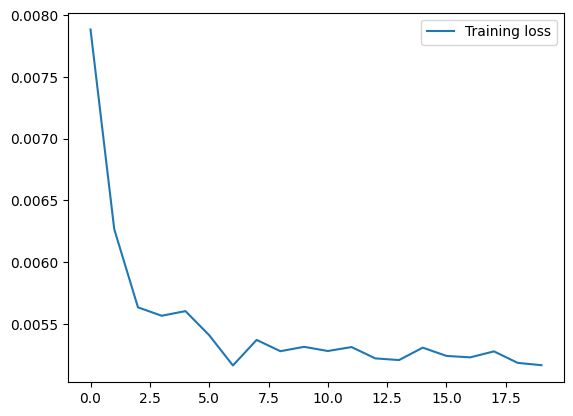

In [57]:
plt.plot(history.history['loss'], label='Training loss')
plt.legend()

In [58]:
last_train_batch = scaler_train[-n_inputs:]
last_train_batch = last_train_batch.reshape((1, n_inputs, n_features))


In [45]:
last_train_batch.reshape((1, n_inputs, n_features))

array([[[0.04658305],
        [0.06410005],
        [0.08744026],
        [0.06350333],
        [0.0492603 ],
        [0.05743698],
        [0.04319133],
        [0.04944078],
        [0.05738288],
        [0.06077967]]])

In [59]:
model.predict(last_train_batch)

1/1 [==============================] - 1s 830ms/step


array([[0.04600401]], dtype=float32)

In [60]:
scaler_test[0]

array([0.05785832])

In [133]:
test_predictions = []


first_eval_batch = scaler_train[-n_inputs:]
current_batch = first_eval_batch.reshape((1, n_inputs, n_features))

contador = 0

for i in range(len(test)):
    clear_output(wait=True)
    current_test = scaler_test[contador]
    contador = contador + 1
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)



    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_test]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [134]:

mean_predictions = []

first_eval_batch = scaler_train[-n_inputs:]
current_batch = first_eval_batch.reshape((1, n_inputs, n_features))

contador = 0

for i in range(len(test)):
    clear_output(wait=True)
    current_test = scaler_test[contador]
    contador = contador + 1
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]


    current_pred[0] = np.array(np.mean(current_batch))
    mean_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_test]],axis=1)

1/1 [==============================] - 0s 21ms/step


In [135]:
test_predictions[:10]

[array([0.04600401], dtype=float32),
 array([0.04483692], dtype=float32),
 array([0.06013004], dtype=float32),
 array([0.0486761], dtype=float32),
 array([0.0410168], dtype=float32),
 array([0.03597631], dtype=float32),
 array([0.04194938], dtype=float32),
 array([0.02765952], dtype=float32),
 array([0.03505248], dtype=float32),
 array([0.03343891], dtype=float32)]

In [136]:
mean_predictions[:10]

[array([0.05364633], dtype=float32),
 array([0.0537306], dtype=float32),
 array([0.06160365], dtype=float32),
 array([0.06366766], dtype=float32),
 array([0.05944184], dtype=float32),
 array([0.05251788], dtype=float32),
 array([0.04990943], dtype=float32),
 array([0.03918255], dtype=float32),
 array([0.03639045], dtype=float32),
 array([0.03832671], dtype=float32)]

In [119]:
current_pred

array([0.09672286], dtype=float32)

In [116]:
current_pred[0]= np.array(0.099)
current_pred

array([0.099], dtype=float32)

In [137]:
true_predictions = scaler.inverse_transform(test_predictions)
true_mean_predictions = scaler.inverse_transform(mean_predictions)

In [121]:
test.head()

,Volume,Volume_predictions,Volume_Mean
Date,,,
2018-02-28,37568080,35668612,35668612
2018-03-01,48706170,35706613,35706613
2018-03-02,38426060,39257095,39257095
2018-03-05,27825140,40187897,40187897
2018-03-06,23273160,38282192,38282192


In [ ]:
true_predictions

In [ ]:
test['Volume_predictions'] = true_predictions
test['Volume_predictions'] = test['Volume_predictions'].astype(int)
test['Volume_Mean'] = true_mean_predictions
test['Volume_Mean'] = test['Volume_Mean'].astype(int)

In [139]:
test.tail()

,Volume,Volume_predictions,Volume_Mean
Date,,,
2020-02-24,55548830,27161705,27856579
2020-02-25,57668360,39018969,34960655
2020-02-26,49678430,39376348,38856218
2020-02-27,80151380,39917154,44092706
2020-02-28,106721200,63453305,55094682


<Axes: xlabel='Date'>

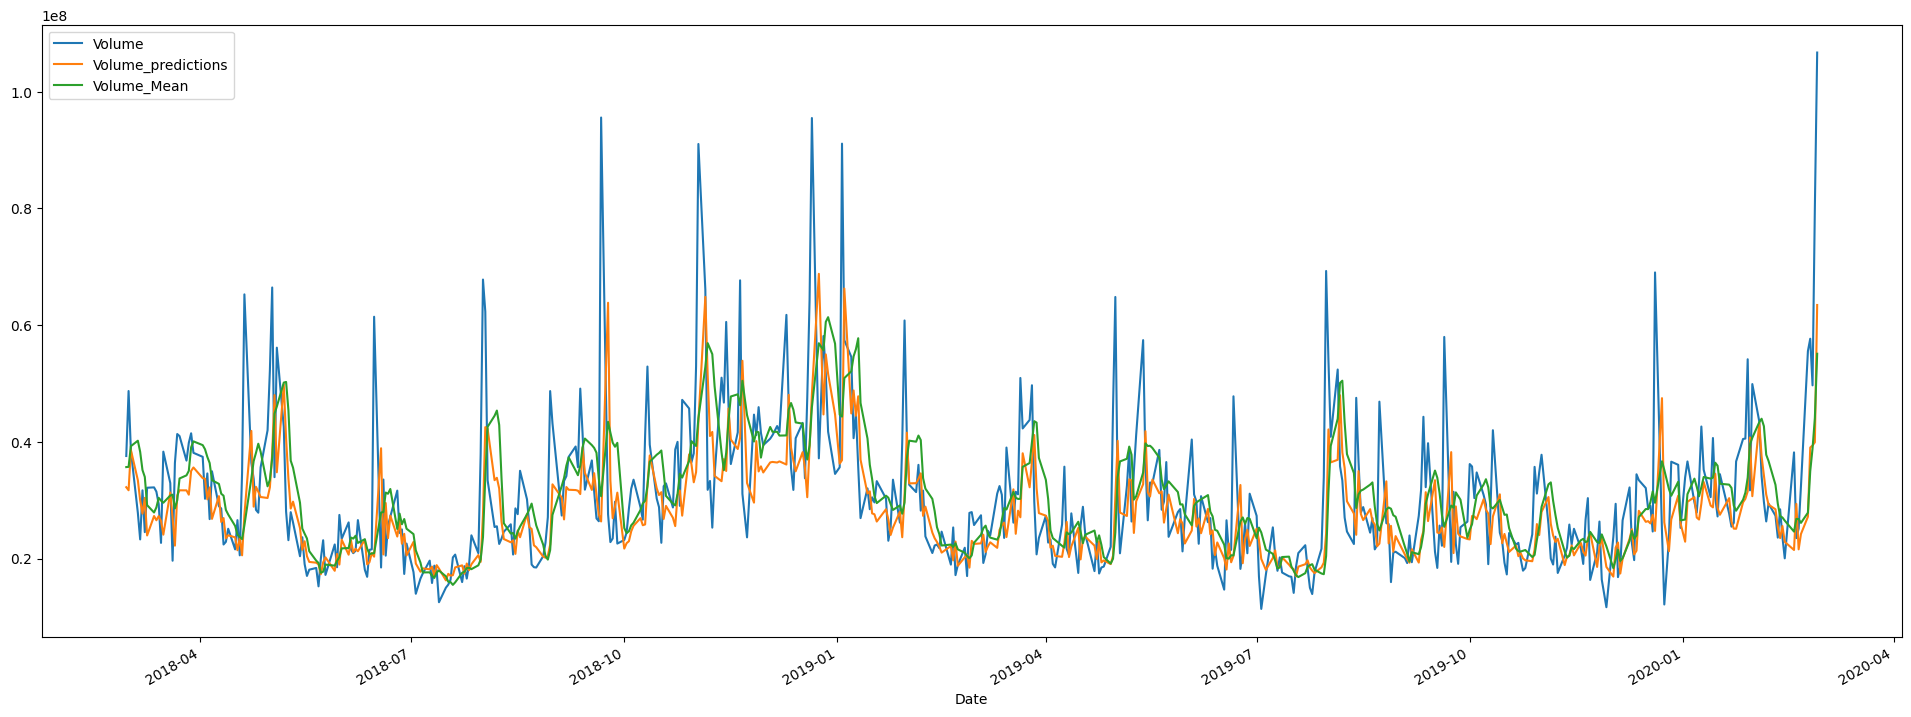

In [145]:
test.plot(figsize=(24,9))

In [141]:
rmse = sqrt(mean_squared_error(test['Volume'],test['Volume_predictions']))
print(rmse)

11273778.38263351


In [142]:
rmse = sqrt(mean_squared_error(test['Volume'],test['Volume_Mean']))
print(rmse)

11736619.61579752
